In [1]:
import pandas as pd, numpy as np
import pymysql, re, collections
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

from pathlib import Path
from tqdm import tqdm
from datetime import datetime
from collections import Counter
from wordcloud import WordCloud
from konlpy.tag import Okt
from PIL import Image

from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer

pd.set_option('display.max_columns', None)

def live_db_conn():
    conn = pymysql.connect(host='host', user='user', password='password',autocommit=True,cursorclass=pymysql.cursors.DictCursor, db = "database")
    return conn

def dev_01_db_conn() :
    conn = pymysql.connect(host='host', user='user', password='password',autocommit=True,cursorclass=pymysql.cursors.DictCursor, db = "database")
    return conn

def dev_raw_db_conn() :
    conn = pymysql.connect(host='host', user='user', password='password',autocommit=True,cursorclass=pymysql.cursors.DictCursor, db = "database")
    return conn

import warnings
warnings.filterwarnings('ignore')

def get_target(target):

    conn = live_db_conn()
    curs = conn.cursor()

    sql = """
    SELECT o.user_id, v.id voucher_id, o.id order_id, op.product_id, store_id, channel_id, code, ota_id, o.order_type, o.status, o.order_lang, need_confirm, order_price, cancel_price, op.promotion_price, currency, title, order_at, reserved_at, v.status, person  
    FROM `order` o
    INNER JOIN order_product op
    INNER JOIN channel c
    inner join voucher v
    on o.channel_id = c.id
    and o.id = op.order_id
    and o.id = v.order_id
    where o.store_id = {} 
    """.format(target)
    curs.execute(sql)

    pms_order = pd.DataFrame(curs.fetchall())

    curs.close()
    conn.close()

    return pms_order

def year_month_day(df, col):

    ymd_dic = {'year':0, 'month':1, 'day':2}

    df['{}'.format(col)] = df['year-month-day'].apply(lambda x:x.split('-')[ymd_dic[col]])

    return df

def to_datetime(string):

    dt = datetime.strptime(string, '%Y-%m-%d')

    return dt

def to_N_week(dt):

    N_week = datetime.strftime(dt, '%G-%V').split('-')[1]

    return N_week

def change_day(year,month,day):

    date = datetime(int(year), int(month), int(day))
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    day = date.weekday()
    day = days[day]

    return day

def to_ymd(string):

    splited = string.split('-')
    
    # yyyy-mm-dd
    if len(splited) == 3:

        year, month, day = splited

        return year, month, day
    
    # yyyy-mm
    elif len(splited) == 2:

        year, month = splited

        return year, month

def order_table():

    conn = live_db_conn()
    curs = conn.cursor()

    sql = """
    SELECT o.id, o.ota_id, o.order_type, o.order_price, o.cancel_price
    FROM `order` o
    """
    curs.execute(sql)

    order = pd.DataFrame(curs.fetchall())
    order = order[order['order_type'] != 'b2b']
    order['real_price'] = order['order_price'] - order['cancel_price']

    curs.close()
    conn.close()

    return order

### 1. Ï†ÑÏ≤òÎ¶¨

In [2]:
def total_preprocessing(target_store):

    pms_order = get_target(target_store)

    pms_order['year-month-day'] = pms_order['reserved_at'].apply(lambda x:str(x).split(' ')[0])

    ymd_list = ['year','month','day']

    for ymd in ymd_list:

        pms_order = year_month_day(pms_order, ymd)

    pms_order['week'] = pms_order['year-month-day'].apply(lambda x:to_N_week(to_datetime(x)))

    pms_order['day_7'] = pms_order.apply(lambda x:change_day(x['year'], x['month'], x['day']), axis=1)

    pms_order['hour-min-sec'] = pms_order['reserved_at'].apply(lambda x:str(x).split(' ')[1])
    pms_order['hour'] = pms_order['hour-min-sec'].apply(lambda x:x.split(':')[0])
    pms_order.drop(['hour-min-sec'],axis=1,inplace=True)

    pms_order['person_num_list'] = pms_order['person'].apply(lambda x:[int(x) for x in re.findall(r'\d+',str(x))])
    pms_order['person_num'] = pms_order['person_num_list'].apply(lambda x:sum(x))
    pms_order.drop(['person','person_num_list'],axis=1,inplace=True)
    pms_order.loc[pms_order['person_num'] > 20,'person_num'] = 2
    pms_order.sort_values(by='reserved_at', inplace=True)
    
    pms_order['real_price'] = pms_order['order_price'] - pms_order['cancel_price']
    
    return pms_order

In [3]:
target = 14970

pms_order = total_preprocessing(target)

### 2. Î∂ÑÏÑù ÏöîÍµ¨ÏÇ¨Ìï≠ Íµ¨ÌòÑ Ìï®Ïàò

1. Í∞úÎ≥Ñ Í≤∞Ï†ú Í∏àÏï° / ÎàÑÏ†ÅÌï© Í∑∏ÎûòÌîÑ

- Í∏∞Í∞ÑÏù¥ Íµ≥Ïù¥ ÏïàÌïÑÏöîÌï† Í≤É Í∞ôÎã§, Í∑∏ÎÉ• Ï†ÑÏ≤¥ Í∏∞Í∞ÑÏù¥ ÎîîÌè¥Ìä∏. Í∑∏Î¶¨Í≥† Ï£º, ÏùºÎ≥Ñ ÌïÑÌÑ∞ÎèÑ Íµ≥Ïù¥ ÏïàÌïÑÏöîÌï† Í≤É Í∞ôÏúºÎØÄÎ°ú ÎîîÌè¥Ìä∏Î°ú ÏõîÎ≥Ñ
- ÎàÑÏ†ÅÏùÑ ÌïÑÌÑ∞Î°ú ÏÑ§Ï†ïÌïòÎäî Í≤ÉÏù¥ ÏïÑÎãàÎùº Í∑∏ÎÉ• 2Í∞ú Îã§ Î≥¥Ïó¨Ï£ºÎäî Í±∏Î°ú?

In [4]:
def get_ota_info():

    order = order_table()
    
    # OTA ÏòàÏïΩ Í±¥ ÎπÑÏú®
    order_ratio = 0
    for i in range(1,15):
        order_ratio += len(order[order['ota_id'] == i]) / len(order)

    # OTA Îß§Ï∂ú ÎπÑÏú®

    ota_list = [i for i in range(1,15)]
    price_ratio = 0
    for ota in ota_list:

        try:

            price_ratio += int(order[order['ota_id'] == ota]['real_price'].sum()) / int(order['real_price'].sum())

        except:

            price_ratio += 0

    return order_ratio, price_ratio

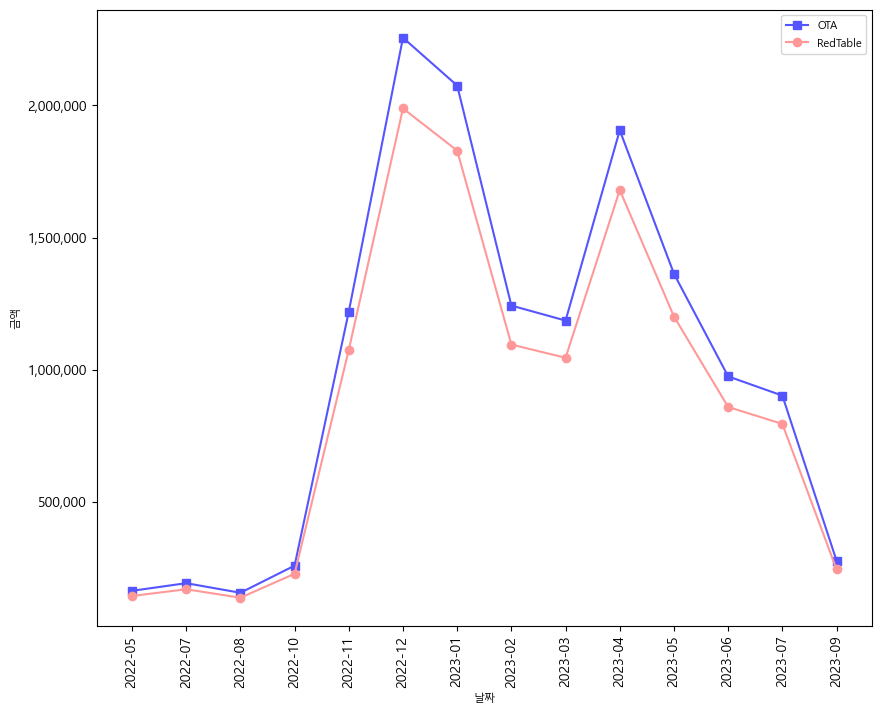

In [5]:
def Real_Price_each(df, is_cumsum):

    df = df.drop_duplicates('order_id')
    df = df[df['v.status'] == 'used']    
    
    plt.figure(figsize=(10,8)) # Ï∞®Ìä∏ ÏÉùÏÑ± Î∞è ÏÇ¨Ïù¥Ï¶à ÏÑ§Ï†ï

    price_ratio = get_ota_info()[1]

    if is_cumsum == False:

        df = df.groupby(['year','month'])['real_price'].sum().reset_index()
        df['year-month'] = df['year'] + '-' + df['month']
        plt.plot(df['year-month'], [float(i) * (1+price_ratio) for i in df['real_price'].values.tolist()], label='OTA', color = '#5555ff', marker = 's')
        plt.plot(df['year-month'], df['real_price'], label='RedTable', color='#ff9999', marker = 'o')

    elif is_cumsum == True:

        df = df.groupby(['year','month'])['real_price'].sum().reset_index()
        df['cumsum'] = df['real_price'].cumsum()
        df['year-month'] = df['year'] + '-' + df['month']

        plt.plot(df['year-month'], [float(i) * (1+price_ratio) for i in df['cumsum'].values.tolist()], label='OTA', color = '#5555ff', marker = 's')
        plt.plot(df['year-month'], df['cumsum'], label='RedTable', color='#ff9999', marker = 'o')

    plt.ylabel('Í∏àÏï°', fontsize=8, loc='center') # xÏ∂ï ÏÑ§Ï†ï
    plt.xlabel('ÎÇ†Ïßú', fontsize=8, loc='center') # yÏ∂ï ÏÑ§Ï†ï

    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    plt.xticks(rotation=90)
    plt.legend(fontsize=8, loc='best') # Î≤îÎ°Ä ÏÑ§Ï†ï bestÎ°ú Ìï¥ÎÜìÏúºÎ©¥ Í∞ÄÏû• Ï†ÅÏ†àÌïú ÏúÑÏπòÏóê ÏïåÏïÑÏÑú Î≤îÎ°ÄÍ∞Ä ÎÜìÏù¥Í≤å Îê©ÎãàÎîî
    
    plt.show()

    return df

Real_Price_each_df = Real_Price_each(pms_order, False)

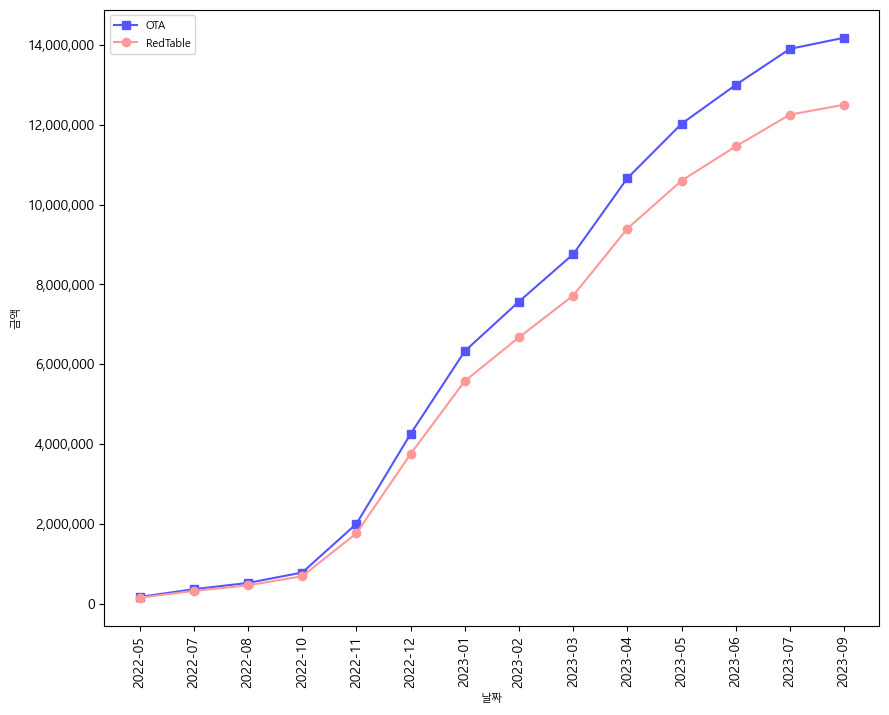

In [6]:
def Real_Price_cumsum(df, is_cumsum):

    df = df.drop_duplicates('order_id')
    df = df[df['v.status'] == 'used']

    price_ratio = get_ota_info()[1]

    plt.figure(figsize=(10,8)) # Ï∞®Ìä∏ ÏÉùÏÑ± Î∞è ÏÇ¨Ïù¥Ï¶à ÏÑ§Ï†ï
    
    if is_cumsum == False:

        df = df.groupby(['year','month'])['real_price'].sum().reset_index()
        df['year-month'] = df['year'] + '-' + df['month']
        plt.plot(df['year-month'], [float(i) * (1+price_ratio) for i in df['real_price'].values.tolist()], label='OTA', color = '#5555ff', marker = 's')
        plt.plot(df['year-month'], df['real_price'], label='RedTable', color='#ff9999', marker = 'o')


    elif is_cumsum == True:

        df = df.groupby(['year','month'])['real_price'].sum().reset_index()
        df['cumsum'] = df['real_price'].cumsum()
        df['year-month'] = df['year'] + '-' + df['month']

        plt.plot(df['year-month'], [float(i) * (1+price_ratio) for i in df['cumsum'].values.tolist()], label='OTA', color = '#5555ff', marker = 's')
        plt.plot(df['year-month'], df['cumsum'], label='RedTable', color='#ff9999', marker = 'o')

    plt.ylabel('Í∏àÏï°', fontsize=8, loc='center') 
    plt.xlabel('ÎÇ†Ïßú', fontsize=8, loc='center') 

    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    plt.xticks(rotation=90)
    plt.legend(fontsize=8, loc='best') 
    
    plt.show()

    return df

Real_Price_cumsum_df = Real_Price_cumsum(pms_order, True)

2. ÏöîÏùºÎ≥Ñ Í≤∞Ï†ú Í∏àÏï° Ìï©

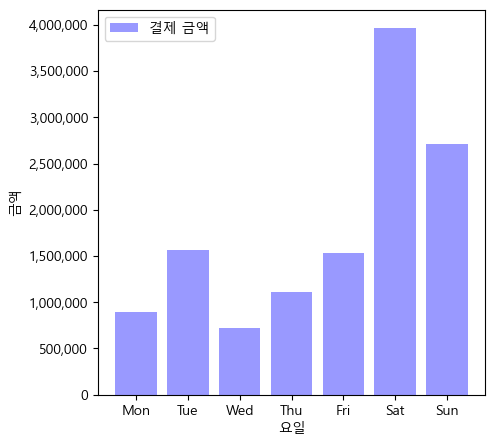

In [7]:
def daily7_RealPrice(df):
    
    df = df[df['v.status'] == 'used']
    df = df.drop_duplicates('order_id')

    day7_dic = {'Mon':0,'Tue':1,'Wed':2,'Thu':3,'Fri':4,'Sat':5,'Sun':6}
    reverse_day7_dic = {v:k for k,v in day7_dic.items()}
    df_Group_BY = df.groupby(['day_7'])['real_price'].sum().reset_index()
    df_Group_BY['day_7'] = df_Group_BY['day_7'].apply(lambda x:day7_dic[x])
    df_Group_BY.sort_values(by='day_7', inplace=True)
    df_Group_BY['day_7'] = df_Group_BY['day_7'].apply(lambda x:reverse_day7_dic[x])
    df_Group_BY.set_index(np.arange(0,len(df_Group_BY)),inplace=True)
    plt.figure(figsize=(5,5))
    plt.bar(df_Group_BY['day_7'], df_Group_BY['real_price'], label='Í≤∞Ï†ú Í∏àÏï°', color='#9999ff')
    
    plt.ylabel('Í∏àÏï°', fontsize=10, loc='center') 
    plt.xlabel('ÏöîÏùº', fontsize=10, loc='center') 

    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    
    plt.legend(fontsize=10, loc='best') 

    plt.show()

    
daily7_RealPrice(pms_order)

3. Í≤∞Ï†ú Í∏àÏï° Ï°∞Ìöå

In [8]:
def Sum_RealPrice(df, string):

    df = df.drop_duplicates('order_id')
    
    cond1 = df['year-month-day'] == string
    cond2 = df['v.status'] == 'used'
    total_cond = cond1 & cond2
    conditioned_df = df[total_cond]

    mop = int(conditioned_df['real_price'].sum())

    return mop

Order_Price_Sum = Sum_RealPrice(pms_order, '2023-09-16')

Order_Price_Sum

246000

6. ÏòàÏïΩ Ïàò(ÎàÑÏ†Å + OTA)

- ÏõîÎ≥Ñ Í±¥ÏàòÎ•º Î≥¥Ïó¨Ï£ºÎ©∞ Ï∂îÏÑ∏Î•º Î≥¥Ïó¨Ï£ºÎäî Í≤ÉÎ≥¥Îã§Îäî ÎàÑÏ†ÅÏùÑ Î≥¥Ïó¨Ï£ºÍ≥† Ïù¥Ïóê OTAÏùò Ìö®Í≥ºÎ•º Î≥¥Ïó¨Ï£ºÎäî Í≤ÉÏù¥ Ï†êÏ£ºÏùò Ïï°ÏÖòÏùÑ Îçî Ïù¥ÎÅåÏñ¥ÎÇº Í≤ÉÏù¥ÎùºÍ≥† ÌåêÎã®

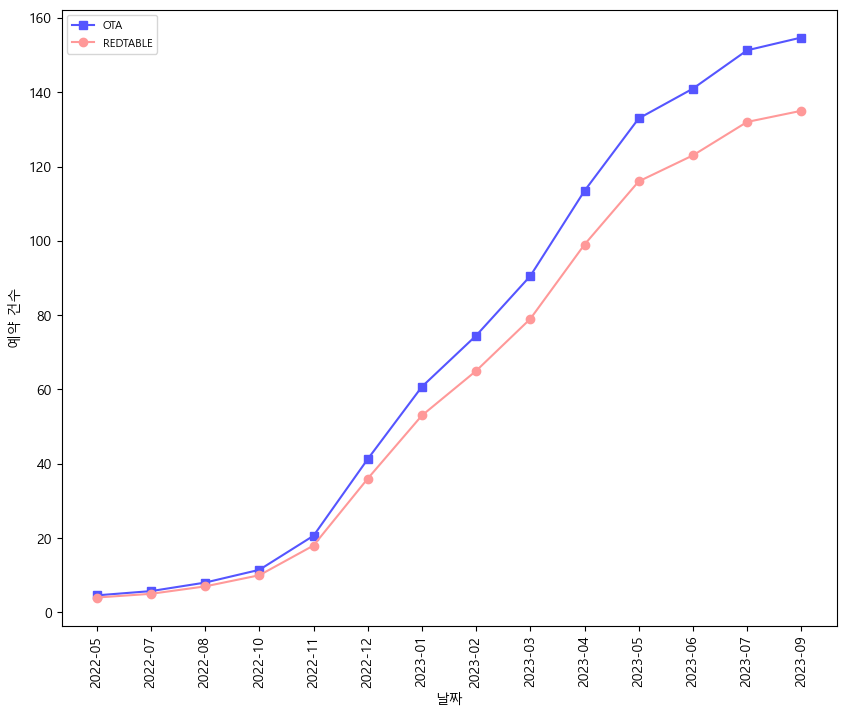

In [9]:
def paid_order(df):

    df = df[(df['status'] == 'paid') & (df['v.status'] == 'used')]
    df = df.drop_duplicates('order_id')

    order_ratio = get_ota_info()[0]
    
    plt.figure(figsize=(10, 8)) # Ï∞®Ìä∏ ÏÉùÏÑ± Î∞è ÏÇ¨Ïù¥Ï¶à ÏÑ§Ï†ï

    df = df.groupby(['year','month'])['order_id'].nunique().reset_index()
    df['year-month'] = df['year'] + '-' + df['month']
    plt.plot(df['year-month'], [float(i) * (1+order_ratio) for i in df['order_id'].cumsum().values.tolist()], label='OTA', color = '#5555ff', marker = 's')
    plt.plot(df['year-month'], df['order_id'].cumsum(), label='REDTABLE', color='#ff9999', marker = 'o')
            
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    # plt.title('ÏòàÏïΩ Í±¥Ïàò', fontsize=10) # ÌÉÄÏù¥ÌãÄ ÏÑ§Ï†ï
    plt.ylabel('ÏòàÏïΩ Í±¥Ïàò', fontsize=10) # xÏ∂ï ÏÑ§Ï†ï
    plt.xlabel('ÎÇ†Ïßú', fontsize=10) # yÏ∂ï ÏÑ§Ï†ï
    plt.xticks(rotation=90)
    plt.legend(fontsize=8, loc='best') # Î≤îÎ°Ä ÏÑ§Ï†ï bestÎ°ú Ìï¥ÎÜìÏúºÎ©¥ Í∞ÄÏû• Ï†ÅÏ†àÌïú ÏúÑÏπòÏóê ÏïåÏïÑÏÑú Î≤îÎ°ÄÍ∞Ä ÎÜìÏù¥Í≤å Îê©ÎãàÎîî

    plt.show()

    return df

paid_order_df = paid_order(pms_order)

7. Í∏∞Ï§ÄÎ≥Ñ ÏòàÏïΩÏûê Ïàò

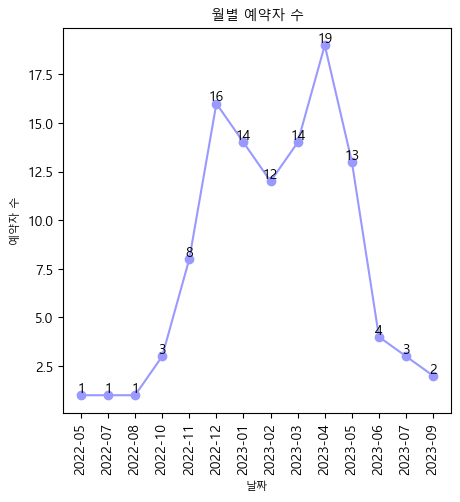

In [10]:
def yearly_N_users(df):
    
    df = df[df['v.status'] == 'used']
    no_duplc = df.drop_duplicates(['year','user_id'])
    gb1 = no_duplc.groupby(['year'])['user_id'].value_counts().reset_index()
    gb2 = gb1.groupby(['year'])['count'].sum().reset_index()
    gb2.columns = ['a','b']

    return gb2

def monthly_N_users(df):

    df = df[df['v.status'] == 'used']
    no_duplc = df.drop_duplicates(['year','month','user_id'])
    gb1 = no_duplc.groupby(['year','month'])['user_id'].value_counts().reset_index()
    gb2 = gb1.groupby(['year','month'])['count'].sum().reset_index()
    gb2['year-month'] = gb2['year'] + '-' + gb2['month']
    gb2 = gb2.drop(['year','month'],axis=1)
    gb2.columns = ['b','a']
    
    return gb2

def daily_N_users(df):
    
    df = df[df['v.status'] == 'used']
    no_duplc = df.drop_duplicates(['year','month','day','user_id'])
    gb1 = no_duplc.groupby(['year','month','day'])['user_id'].value_counts().reset_index()
    gb2 = gb1.groupby(['year','month','day'])['count'].sum().reset_index()
    gb2['year-month-day'] = gb2['year'] + '-' + gb2['month'] + '-' + gb2['day']
    gb2 = gb2.drop(['year','month','day'],axis=1)
    gb2.columns = ['a','b']

    return gb2

def N_users(df, time_criteria):
    
    if time_criteria == 'Ïó∞Î≥Ñ':

        df = yearly_N_users(df)
        
    elif time_criteria == 'ÏõîÎ≥Ñ':

        df = monthly_N_users(df)

    elif time_criteria == 'ÏùºÎ≥Ñ':

        df = daily_N_users(df)

    graph_title = time_criteria + ' ÏòàÏïΩÏûê Ïàò'

    plt.figure(figsize=(5, 5))
    plt.plot(df['a'], df['b'], label='users', color='#9999ff', marker = 'o')

    for i in range(len(df)):
        plt.text(df['a'][i], df['b'][i], df['b'][i], ha='center', va='bottom')

    plt.title(graph_title, fontsize=10) # ÌÉÄÏù¥ÌãÄ ÏÑ§Ï†ï
    plt.ylabel('ÏòàÏïΩÏûê Ïàò', fontsize=8) # xÏ∂ï ÏÑ§Ï†ï
    plt.xlabel('ÎÇ†Ïßú', fontsize=8) # yÏ∂ï ÏÑ§Ï†ï
    plt.xticks(rotation=90)


    plt.show()

N_users(pms_order, 'ÏõîÎ≥Ñ')

8. ÏõîÎ≥Ñ ÏÇ¨Ïö©Îêú Î∞îÏö∞Ï≤ò Ïàò

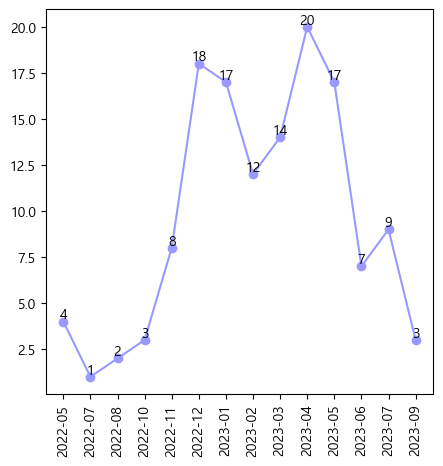

In [11]:
def N_used_vouchers(df):

    df = df.drop_duplicates('order_id')
    
    cond = df['v.status'] == 'used'

    conditioned_df = df[cond]

    # no_duplc = conditioned_df.drop_duplicates(['year','month','voucher_id'])
    gb1 = conditioned_df.groupby(['year','month'])['voucher_id'].value_counts().reset_index()
    gb2 = gb1.groupby(['year','month'])['count'].sum().reset_index()
    gb2['year-month'] = gb2['year'] + '-' + gb2['month']
    gb2 = gb2.drop(['year','month'],axis=1)
    gb2.columns = ['b','a']
    
    plt.figure(figsize=(5, 5))
    plt.plot(gb2['a'], gb2['b'], label='users', color='#9999ff', marker = 'o')

    for i in range(len(gb2)):
        plt.text(gb2['a'][i], gb2['b'][i], gb2['b'][i], ha='center', va='bottom')
    plt.xticks(rotation=90)
    plt.show()

N_used_vouchers(pms_order)

9. Í∏∞Í∞Ñ ÎÇ¥ Ïñ∏Ïñ¥Î≥Ñ ÏÇ¨Ïö©Ïûê Ïàò

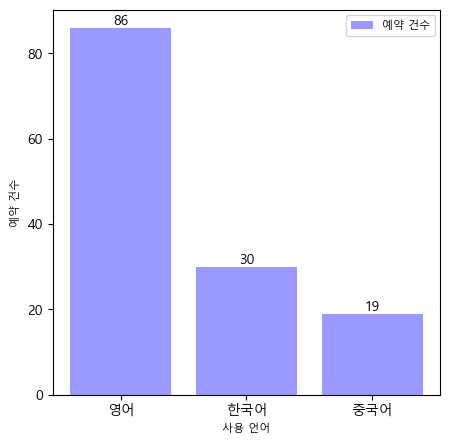

In [12]:
def N_used_langs(df):

    df = df[df['v.status'] == 'used']
    df = df.drop_duplicates('order_id')
    
    lang_vc = df['order_lang'].value_counts().reset_index()
    lang_dic = {'en':'ÏòÅÏñ¥','ko':'ÌïúÍµ≠Ïñ¥','zh-Hans':'Ï§ëÍµ≠Ïñ¥'}
    lang_vc['order_lang'] = lang_vc['order_lang'].apply(lambda x:lang_dic[x])
    plt.figure(figsize=(5,5))
    plt.bar(lang_vc['order_lang'], lang_vc['count'], label='ÏòàÏïΩ Í±¥Ïàò', facecolor='#9999ff')
    # plt.title('ÏÇ¨Ïö© Ïñ∏Ïñ¥ Î≥Ñ ÏòàÏïΩ Í±¥Ïàò', fontsize=10) # ÌÉÄÏù¥ÌãÄ ÏÑ§Ï†ï
    plt.ylabel('ÏòàÏïΩ Í±¥Ïàò', fontsize=8) # xÏ∂ï ÏÑ§Ï†ï
    plt.xlabel('ÏÇ¨Ïö© Ïñ∏Ïñ¥', fontsize=8) # yÏ∂ï ÏÑ§Ï†ï

    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    
    plt.legend(fontsize=8, loc='best') # Î≤îÎ°Ä ÏÑ§Ï†ï bestÎ°ú Ìï¥ÎÜìÏúºÎ©¥ Í∞ÄÏû• Ï†ÅÏ†àÌïú ÏúÑÏπòÏóê ÏïåÏïÑÏÑú Î≤îÎ°ÄÍ∞Ä ÎÜìÏù¥Í≤å Îê©ÎãàÎîî

    for i in range(len(lang_vc)):
        plt.text(lang_vc['order_lang'][i], lang_vc['count'][i], lang_vc['count'][i], ha='center', va='bottom')
    
    plt.show()

N_used_langs(pms_order)

10. ÌèâÍ∑† ÌåÄÎãπ Ïù∏Ïõê Ïàò

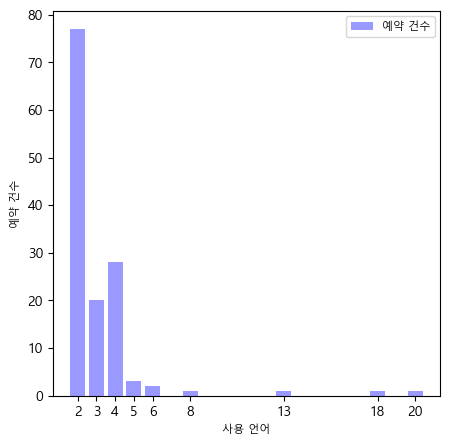

'ÏòàÏïΩ ÌåÄÎãπ ÏµúÎã§ Ïù∏Ïõê ÏàòÎäî 20Î™ÖÏù¥Î©∞, Í∞ÄÏû• ÎßéÏùÄ ÏòàÏïΩÏù¥ Î∞úÏÉùÌïú ÌåÄÏùò Ïù∏Ïõê ÏàòÎäî 2Î™ÖÏûÖÎãàÎã§. ÏòàÏïΩ ÌåÄÎãπ ÌèâÍ∑† Ïù∏Ïõê ÏàòÎäî 3.05Î™ÖÏûÖÎãàÎã§. '

In [13]:
def N_person_avg_per_team(df):
    
    df = df.drop_duplicates('order_id')
    df = df[df['v.status'] == 'used']
    # df = df[(df['reserved_at'] >= start_date) & (df['reserved_at'] <= end_date)]
    pn_dic = dict(df['person_num'].value_counts().sort_index())
    pn_dic = {k:v for k,v in pn_dic.items() if k >= 1}

    max_order_num = df['person_num'].value_counts().index[0]
    N_max = df['person_num'].max()
    N_avg = df['person_num'].mean()

    plt.figure(figsize=(5,5))
    plt.bar(list(pn_dic.keys()), list(pn_dic.values()), label='ÏòàÏïΩ Í±¥Ïàò', facecolor='#9999ff')
    # plt.title('ÏÇ¨Ïö© Ïñ∏Ïñ¥ Î≥Ñ ÏòàÏïΩ Í±¥Ïàò', fontsize=10) # ÌÉÄÏù¥ÌãÄ ÏÑ§Ï†ï
    plt.ylabel('ÏòàÏïΩ Í±¥Ïàò', fontsize=8) # xÏ∂ï ÏÑ§Ï†ï
    plt.xlabel('ÏÇ¨Ïö© Ïñ∏Ïñ¥', fontsize=8) # yÏ∂ï ÏÑ§Ï†ï
    plt.xticks(list(pn_dic.keys()))
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    
    plt.legend(fontsize=8, loc='best')
    plt.show()
    text = "ÏòàÏïΩ ÌåÄÎãπ ÏµúÎã§ Ïù∏Ïõê ÏàòÎäî {}Î™ÖÏù¥Î©∞, Í∞ÄÏû• ÎßéÏùÄ ÏòàÏïΩÏù¥ Î∞úÏÉùÌïú ÌåÄÏùò Ïù∏Ïõê ÏàòÎäî {}Î™ÖÏûÖÎãàÎã§. ÏòàÏïΩ ÌåÄÎãπ ÌèâÍ∑† Ïù∏Ïõê ÏàòÎäî {}Î™ÖÏûÖÎãàÎã§. ".format(N_max, max_order_num, round(N_avg,2))

    return text

person_avg_per_team = N_person_avg_per_team(pms_order)

person_avg_per_team

11. ÏµúÎã§ ÌåêÎß§ ÏÉÅÌíà

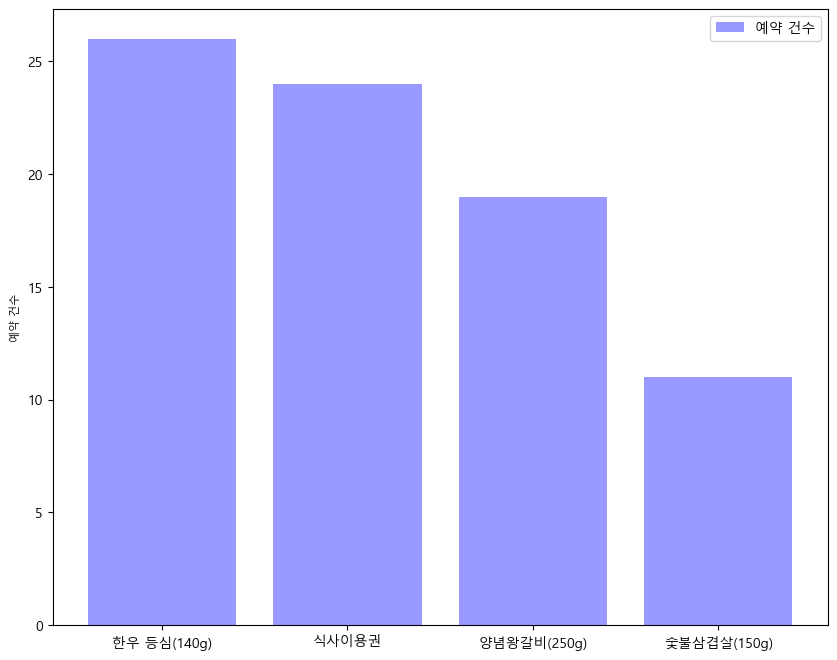

'ÏµúÎã§ ÌåêÎß§ ÏÉÅÌíàÏùÄ [ÌïúÏö∞ Îì±Ïã¨(140g)] ÏÉÅÌíàÏúºÎ°ú, Ï¥ù 26Í±¥Ïùò ÏòàÏïΩ Í±¥ÏàòÍ∞Ä ÏûàÏäµÎãàÎã§.'

In [14]:
def hot_product(df):

    df = df[df['v.status'] == 'used']
    df = df.drop_duplicates('order_id')

    top5_idx = df['product_id'].value_counts()[:5].index.tolist()
    top5_vals = df['product_id'].value_counts()[:5].values.tolist()

    conn = live_db_conn()
    curs = conn.cursor()

    sql = """
    SELECT id, name, price
    FROM product
    where id in {}
    """.format(tuple(top5_idx))
    curs.execute(sql)

    product = pd.DataFrame(curs.fetchall())

    curs.close()
    conn.close()
    idx_name = {idx:product[product['id'] == idx]['name'].values[0] for idx in top5_idx}
    
    plt.figure(figsize=(10,8))
    plt.bar(idx_name.values(), top5_vals, label='ÏòàÏïΩ Í±¥Ïàò', facecolor='#9999ff')
    plt.ylabel('ÏòàÏïΩ Í±¥Ïàò', fontsize=8) # xÏ∂ï ÏÑ§Ï†ï
    # plt.xlabel('ÏÇ¨Ïö© Ïñ∏Ïñ¥', fontsize=8) # yÏ∂ï ÏÑ§Ï†ï

    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    
    plt.legend(fontsize=10, loc='best') # Î≤îÎ°Ä ÏÑ§Ï†ï bestÎ°ú Ìï¥ÎÜìÏúºÎ©¥ Í∞ÄÏû• Ï†ÅÏ†àÌïú ÏúÑÏπòÏóê ÏïåÏïÑÏÑú Î≤îÎ°ÄÍ∞Ä ÎÜìÏù¥Í≤å Îê©ÎãàÎîî

    # for i in range(len(lang_vc)):
    #     plt.text(lang_vc['order_lang'][i], lang_vc['count'][i], lang_vc['count'][i], ha='center', va='bottom')
    
    plt.show()

    text = 'ÏµúÎã§ ÌåêÎß§ ÏÉÅÌíàÏùÄ [{}] ÏÉÅÌíàÏúºÎ°ú, Ï¥ù {}Í±¥Ïùò ÏòàÏïΩ Í±¥ÏàòÍ∞Ä ÏûàÏäµÎãàÎã§.'.format(list(idx_name.values())[0], top5_vals[0])

    return text

hot_product(pms_order)

12. Ïù∏Í∏∞ ÏãúÍ∞ÑÎåÄ

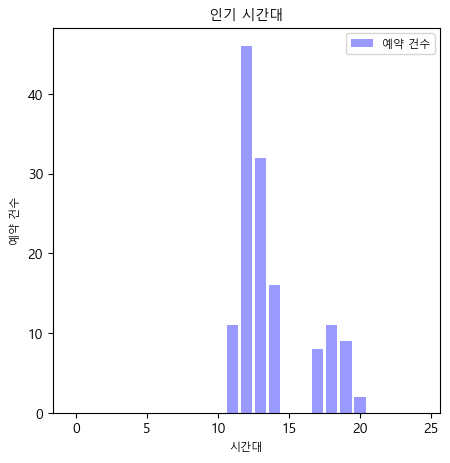

In [15]:
def hot_hour(df):

    df = df[df['v.status'] == 'used']
    df = df.drop_duplicates('order_id')
    hot_hour = df['hour'].value_counts().reset_index()
    hot_hour['hour'] = hot_hour['hour'].apply(lambda x:int(x))
    tmp_list = [[i,0] for i in np.arange(0,25).tolist() if i not in hot_hour['hour'].unique().tolist()]

    for i in range(len(tmp_list)):
        hot_hour= pd.concat([hot_hour, pd.DataFrame([tmp_list[i]],columns=['hour','count'])])
    hot_hour.sort_values(by='hour',inplace=True)

    plt.figure(figsize=(5,5))
    plt.bar(hot_hour['hour'], hot_hour['count'], label='ÏòàÏïΩ Í±¥Ïàò', facecolor='#9999ff')
    plt.title('Ïù∏Í∏∞ ÏãúÍ∞ÑÎåÄ', fontsize=10) # ÌÉÄÏù¥ÌãÄ ÏÑ§Ï†ï
    plt.ylabel('ÏòàÏïΩ Í±¥Ïàò', fontsize=8) # xÏ∂ï ÏÑ§Ï†ï
    plt.xlabel('ÏãúÍ∞ÑÎåÄ', fontsize=8) # yÏ∂ï ÏÑ§Ï†ï

    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    
    plt.legend(fontsize=8, loc='best')
    plt.show()

hot_hour(pms_order)

13. Í≥†Í∞ù ÌòÑÌô© ÎàÑÏ†Å/ÏùºÎ≥Ñ Í∑∏ÎûòÌîÑ

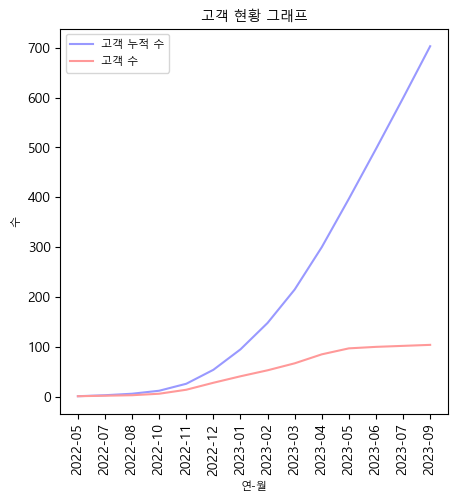

In [16]:
def N_users_cumsum(df):
    
    df = df[df['v.status'] == 'used']
    df = df.drop_duplicates('order_id')

    N_users_cumsum_df = df.drop_duplicates('user_id').groupby(['year','month'])['user_id'].value_counts().cumsum().reset_index().drop('user_id',axis=1).drop_duplicates(['year','month'],keep='last')
    N_users_cumsum_df['year-month'] = N_users_cumsum_df['year'] + '-' + N_users_cumsum_df['month']
    plt.figure(figsize=(5,5)) # Ï∞®Ìä∏ ÏÉùÏÑ± Î∞è ÏÇ¨Ïù¥Ï¶à ÏÑ§Ï†ï

    plt.plot(N_users_cumsum_df['year-month'], N_users_cumsum_df['count'].cumsum(), label='Í≥†Í∞ù ÎàÑÏ†Å Ïàò', color='#9999ff') # CLOU Ï¢ÖÍ∞Ä Î∂àÎü¨Ïò§Í∏∞
    plt.plot(N_users_cumsum_df['year-month'], N_users_cumsum_df['count'], label='Í≥†Í∞ù Ïàò', color='#ff9999')

    plt.title('Í≥†Í∞ù ÌòÑÌô© Í∑∏ÎûòÌîÑ', fontsize=10) # ÌÉÄÏù¥ÌãÄ ÏÑ§Ï†ï
    plt.ylabel('Ïàò', fontsize=8) # xÏ∂ï ÏÑ§Ï†ï
    plt.xlabel('Ïó∞-Ïõî', fontsize=8) # yÏ∂ï ÏÑ§Ï†ï

    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    plt.xticks(rotation=90)
    plt.legend(fontsize=8, loc='best') # Î≤îÎ°Ä ÏÑ§Ï†ï bestÎ°ú Ìï¥ÎÜìÏúºÎ©¥ Í∞ÄÏû• Ï†ÅÏ†àÌïú ÏúÑÏπòÏóê ÏïåÏïÑÏÑú Î≤îÎ°ÄÍ∞Ä ÎÜìÏù¥Í≤å Îê©ÎãàÎîî
    
    plt.show()

N_users_cumsum(pms_order)

In [17]:
def google_review_ethan(store_id):

    conn = dev_raw_db_conn()
    curs = conn.cursor()

    sql = """
    select live_store_id, reviewer_name, reviewer_stars, review_detail, date_detail as date
    from ethan_google_review_detail
    where live_store_id = {}
    """.format(store_id)
    curs.execute(sql)
    google_review = pd.DataFrame(curs.fetchall())

    curs.close()
    conn.close()
    
    google_review.dropna(inplace=True)

    return google_review

def google_review_emile(store_id):

    conn = dev_raw_db_conn()
    curs = conn.cursor()

    sql = """
    SELECT STORE_ID as live_store_id, reviewer_name, reviewer_star as reviewer_stars, review_detail, date_detail as date
    FROM emile_google_review_detail
    where reviewer_star is not null
    and STORE_ID = {}
    """.format(store_id)
    curs.execute(sql)
    google_review = pd.DataFrame(curs.fetchall())

    curs.close()
    conn.close()

    return google_review

def dev_naver_review(store_id):

    conn = dev_raw_db_conn()
    curs = conn.cursor()

    sql = """
    SELECT A.RSTR_ID, A.SRC_ID as store_id, B.SRC_ID as naver_src_id FROM (SELECT * FROM redtable01.RSTR_CONN where SRC='live_db') A
    join (SELECT * FROM redtable01.RSTR_CONN where SRC='naver') B on A.RSTR_id=B.RSTR_id
    where A.SRC_ID = {};
    """.format(store_id)
    curs.execute(sql)
    store_conn = pd.DataFrame(curs.fetchall())

    if len(store_conn) != 0:
        sql = """
        SELECT *
        FROM naver_review
        where rating is not null
        and restaurant_id = {}
        """.format(store_conn['naver_src_id'][0])
        curs.execute(sql)
        naver_review = pd.DataFrame(curs.fetchall())
    
    else:

        naver_review = pd.DataFrame()

    curs.close()
    conn.close()


    return store_conn, naver_review

14. Î¶¨Î∑∞ Ïàò

In [18]:
def change_format(string):

    changed_str = string[:-2].replace('.','-')
    newDate = datetime.strptime(changed_str, '%y-%m-%d')

    return newDate

In [19]:
def N_total_review(store_id, start_date, end_date):

    google_review_ethan_df = google_review_ethan(store_id)
    google_review_emile_df = google_review_emile(store_id)

    google_review = pd.concat([google_review_ethan_df, google_review_emile_df])

    
    store_conn, naver_review = dev_naver_review(store_id)

    if len(naver_review) != 0:
        
        naver_review.drop_duplicates(['writer_id','restaurant_id','visited'], inplace=True)
        naver_review = pd.merge(naver_review, store_conn, how='left', left_on = 'restaurant_id', right_on = 'naver_src_id').drop(['RSTR_ID','naver_src_id'],axis=1)
        naver_review = naver_review[['store_id','writer_id','rating','visited','content']].rename(columns={'store_id':'live_store_id','writer_id':'reviewer_name','rating':'reviewer_stars','content':'review_detail','visited':'date'})
        naver_review['date'] = naver_review['date'].apply(lambda x:change_format(x)) 
        
        total_review = pd.concat([google_review, naver_review])

    else:
    
        total_review = google_review



    try:

        total_review = total_review[(total_review['date'] >= start_date) & (total_review['date'] <= end_date)]
        total_review.sort_values(by='date', inplace=True)
        total_review['year'] = total_review['date'].apply(lambda x:str(x).split('-')[0])
        total_review['month'] = total_review['date'].apply(lambda x:str(x).split('-')[1])

        # plot_df = total_review.groupby(['year','month'])['live_store_id'].value_counts().reset_index()
        # plot_df['year_month'] = plot_df['year'] + '-' + plot_df['month']
        # plt.figure(figsize=(5,5)) # Ï∞®Ìä∏ ÏÉùÏÑ± Î∞è ÏÇ¨Ïù¥Ï¶à ÏÑ§Ï†ï

        # plt.plot(plot_df['year_month'], plot_df['count'].cumsum(), label='Î¶¨Î∑∞ ÎàÑÏ†Å Ïàò', color='#9999ff') # CLOU Ï¢ÖÍ∞Ä Î∂àÎü¨Ïò§Í∏∞
        # plt.plot(plot_df['year_month'], plot_df['count'], label='Î¶¨Î∑∞ Ïàò', color='#ff9999')
        # plt.title('Î¶¨Î∑∞ ÌòÑÌô© Í∑∏ÎûòÌîÑ')
        # plt.ylabel('Î¶¨Î∑∞ Ïàò', fontsize=8) # xÏ∂ï ÏÑ§Ï†ï
        # plt.xlabel('Ïó∞-Ïõî', fontsize=8) # yÏ∂ï ÏÑ§Ï†ï
        # plt.xticks(rotation=90)
        # plt.legend(fontsize=8, loc='best') # Î≤îÎ°Ä ÏÑ§Ï†ï bestÎ°ú Ìï¥ÎÜìÏúºÎ©¥ Í∞ÄÏû• Ï†ÅÏ†àÌïú ÏúÑÏπòÏóê ÏïåÏïÑÏÑú Î≤îÎ°ÄÍ∞Ä ÎÜìÏù¥Í≤å Îê©ÎãàÎîî
        # plt.show()

    except:

        print('Ìï¥Îãπ Í∏∞Í∞ÑÏóê Ï°∞Ìöå Î°úÍ∑∏Í∞Ä ÏóÜÏäµÎãàÎã§.')

    return total_review
    

N_total_review_df = N_total_review(target, '2023-01-01', '2023-05-30')

15. Í≤ÄÏÉâÎüâ (Live_event)

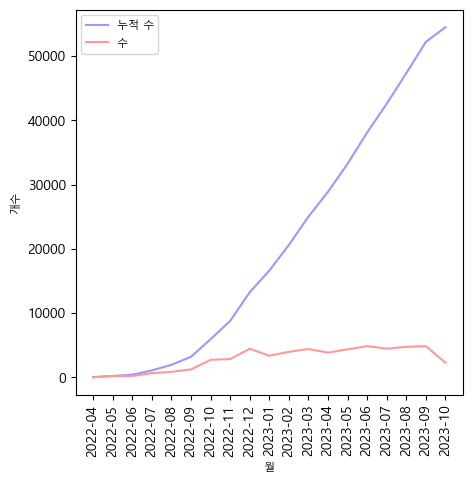

In [20]:
def live_event(store_id, start_date, end_date):

    conn = live_db_conn()
    curs = conn.cursor()

    sql = """
    SELECT * FROM live_event
    where store_id = {} 
    and created_at >= '{}'
    and created_at <= '{}'
    """.format(store_id, start_date, end_date)
    curs.execute(sql)

    live_event = pd.DataFrame(curs.fetchall())

    curs.close()
    conn.close()
    
    try:
        live_event['year'] = live_event['created_at'].apply(lambda x:str(x).split('-')[0])
        live_event['month'] = live_event['created_at'].apply(lambda x:str(x).split('-')[1])

        plot_df = live_event.groupby(['year','month'])['store_id'].value_counts().reset_index()
        plot_df['year_month'] = plot_df['year'] + '-' + plot_df['month']
        plt.figure(figsize=(5, 5)) # Ï∞®Ìä∏ ÏÉùÏÑ± Î∞è ÏÇ¨Ïù¥Ï¶à ÏÑ§Ï†ï

        plt.plot(plot_df['year_month'], plot_df['count'].cumsum(), label='ÎàÑÏ†Å Ïàò', color='#9999ff') # CLOU Ï¢ÖÍ∞Ä Î∂àÎü¨Ïò§Í∏∞
        plt.plot(plot_df['year_month'], plot_df['count'], label='Ïàò', color='#ff9999')

        plt.ylabel('Í∞úÏàò', fontsize=8) # xÏ∂ï ÏÑ§Ï†ï
        plt.xlabel('Ïõî', fontsize=8) # yÏ∂ï ÏÑ§Ï†ï

        # current_values = plt.gca().get_yticks()
        # plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
        plt.xticks(rotation=90)
        plt.legend(fontsize=8, loc='best') # Î≤îÎ°Ä ÏÑ§Ï†ï bestÎ°ú Ìï¥ÎÜìÏúºÎ©¥ Í∞ÄÏû• Ï†ÅÏ†àÌïú ÏúÑÏπòÏóê ÏïåÏïÑÏÑú Î≤îÎ°ÄÍ∞Ä ÎÜìÏù¥Í≤å Îê©ÎãàÎîî
        plt.show()

    except:

        print('Ìï¥Îãπ Í∏∞Í∞ÑÏóê Ï°∞Ìöå Î°úÍ∑∏Í∞Ä ÏóÜÏäµÎãàÎã§.')

live_event(target,'2021-04-01', '2023-12-31')

16. Î¶¨Î∑∞ ÌÇ§ÏõåÎìú

['Ïù¥ Ïû•ÏÜåÎäî Ïö∞Î¶¨ Ïó¨ÌñâÏùò ÌïòÏù¥ÎùºÏù¥Ìä∏ÏûÖÎãàÎã§. Ïö∞Î¶¨Îäî 2Î™ÖÎøêÏù¥ÏóàÍ∏∞ ÎïåÎ¨∏Ïóê Î∞îÎ°ú ÌÖåÏù¥Î∏îÏùÑ ÏñªÏùÑ Ïàò ÏûàÏñ¥ÏÑú Ïö¥Ïù¥ Ï¢ãÏïòÏäµÎãàÎã§. Îçî ÌÅ∞ Í∑∏Î£πÏúºÎ°ú Ïò§Îäî Í≤ΩÏö∞ ÎØ∏Î¶¨ ÏòàÏïΩÌïòÏßÄ ÏïäÎäî Ìïú Í∏∞Îã§Î†§Ïïº Ìï©ÎãàÎã§.\n\nÏö∞Î¶¨Îäî Ïá†Í≥†Í∏∞ ÏÜêÍ∞ÄÎùΩ, ÏÇºÍ≤πÏÇ¥, ÏÉù Ïá†Í≥†Í∏∞ ÌÉÄÎ•¥ÌÉÄÎ•¥, Îß§Ïö¥ ÎÉâÎ©¥ÏùÑ Ï£ºÎ¨∏ÌñàÎäîÎç∞ Î™®Îì† Í≤ÉÏù¥ Ï†àÎåÄÏ†ÅÏúºÎ°ú ÎßõÏûàÏäµÎãàÎã§.\n\nÏù¥Í≥≥Ïùò Î∞ëÎ∞òÏ∞¨ÎèÑ Îã§Î•∏ kbbqÏßëÎ≥¥Îã§ Í≥†Í∏âÏä§ÎüΩÍ≥† ÎßõÎèÑ Ï¢ãÏäµÎãàÎã§.\n\nÎ™®Îì† ÏßÅÏõêÏùÄ Ï¢ãÏùÄ ÏòÅÏñ¥Î•º Íµ¨ÏÇ¨Ìï©ÎãàÎã§. Í∑∏Îì§ÏùÄ Îß§Ïö∞ Ï†ïÏ§ëÌïòÍ≥† Îπ†Î•¥Í≤å ÏùºÌïòÎ©∞ Í≥†Í∏∞ÎèÑ ÏôÑÎ≤ΩÌïòÍ≤å ÏöîÎ¶¨Ìï©ÎãàÎã§.\n\nÏßÅÏõêÏùÄ ÎòêÌïú Í∑∏Îì§Ïù¥ Ï†úÍ≥µÌïòÎäî ÎèºÏßÄ Í≥†Í∏∞Îäî Îß§Ïö∞ Ïã†ÏÑ†ÌïòÏó¨ Í≥†Í∏∞Î•º 80%ÍπåÏßÄ ÏùµÌûê Ïàò ÏûàÎã§Í≥† ÎßêÌï©ÎãàÎã§. ÎÇòÎäî Í∑∏Í≤ÉÏóê ÎåÄÌï¥ ÌôïÏã†ÌïòÏßÄ Î™ªÌñàÍ∏∞ ÎïåÎ¨∏Ïóê Ïö∞Î¶¨Îäî Ïó¨Ï†ÑÌûà Í∑∏Îì§ÏóêÍ≤å 100% ÏöîÎ¶¨Î•º ÏöîÏ≤≠ÌñàÏäµÎãàÎã§ üòå. ÌïòÏßÄÎßå ÏôÄÏö∞, ÎèºÏßÄÍ≥†Í∏∞Î•º ÏïΩÍ∞Ñ ÎÇ† Í≤ÉÏúºÎ°ú Î®πÏùÑ Ïàò ÏûàÎã§Îäî Í≤ÉÏùÑ Î™∞ÎûêÏäµÎãàÍπå?\n\n

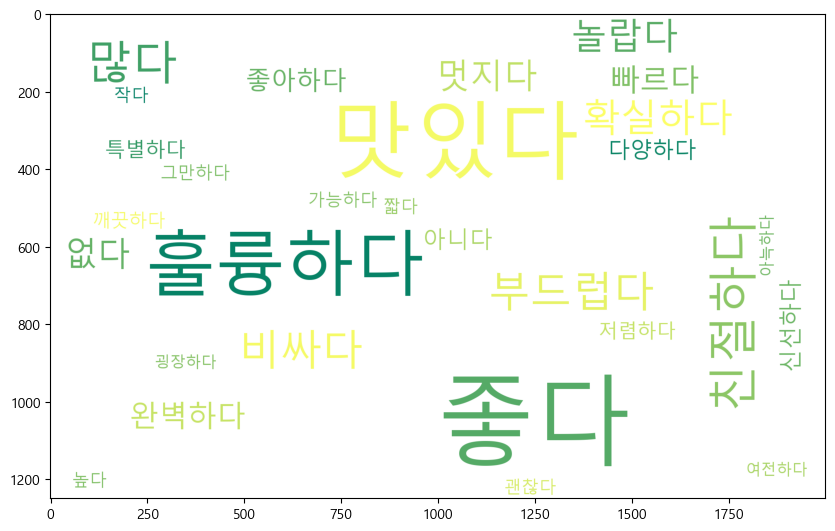

In [24]:
def review_WordCloud(df):

    text = df['review_detail'].tolist()
    review_dic = {}
    okt = Okt()
    review_dic = {}
    total_words = []
    for i in range(len(text)):

        okt_pos = okt.pos(str(text[i]), norm=True, stem=True)
        idx_words = [(x,y[0]) for x,y in enumerate(okt_pos) if len(y[0]) > 1 and y[1] in ['Adjective']] # Îã®Ïñ¥Ïùò Í∏∏Ïù¥Í∞Ä 1Í∞úÏù∏ Í≤ÉÏùÄ Ï†úÏô∏
        stop_words = ['ÌïòÎã§','ÏïäÎã§','Ïù¥Îã§','ÏûàÎã§','Í∑∏Î†áÎã§','Ïã∂Îã§','Í∞ôÎã§','ÎãπÏã†','Ï†ïÎèÑ','Ïù∏Î∂Ñ','Í∑∏Í≤É']
        words = [x[1] for x in idx_words if x[1] not in stop_words]
        total_words.extend(words)
        review_dic[i]=len(words)
        
    sorted_rd = dict(sorted(review_dic.items(),reverse=True, key=lambda x:x[1]))
    top3_review = [text[i] for i in range(len(text)) if i in list(sorted_rd.keys())[:3]]
    
    c = Counter(total_words)
    c = {k:v for k,v in c.items() if v >= 5}
    return_c = dict(sorted(c.items(), key=lambda x:x[1], reverse=True))
    wc = WordCloud(font_path='malgun', width=800, height=500, scale=2.5, max_font_size=100, background_color='white', colormap='summer')
    gen = wc.generate_from_frequencies(c)
    plt.figure(figsize=(10,8))
    plt.imshow(gen)

    return  top3_review, return_c

top3_review, return_c = review_WordCloud(N_total_review_df)

print(top3_review)
print(return_c)

17. Î¶¨Î∑∞ Í∏çÎ∂ÄÏ†ï

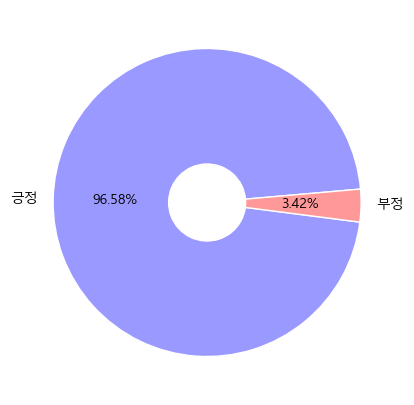

Îß§Ïû•Ïùò Ï¥ù Î¶¨Î∑∞ 1052Í∞ú Ï§ë, Í∏çÏ†ïÏ†Å Î¶¨Î∑∞Îäî 96.5779%, Î∂ÄÏ†ïÏ†Å Î¶¨Î∑∞Îäî 3.42205%ÏûÖÎãàÎã§.


In [22]:
def review_pn_ratio(target):

    conn = dev_raw_db_conn()
    curs = conn.cursor()

    sql = """
    SELECT * 
    FROM thomas_store_review_pn
    where live_store_id = {}
    """.format(target)
    curs.execute(sql)
    review_pn = pd.DataFrame(curs.fetchall())

    curs.close()
    conn.close()
    vals = review_pn.values[0]
    cnt = int(vals[1])
    p = vals[2]
    n = vals[3]
    text = 'Îß§Ïû•Ïùò Ï¥ù Î¶¨Î∑∞ {}Í∞ú Ï§ë, Í∏çÏ†ïÏ†Å Î¶¨Î∑∞Îäî {}%, Î∂ÄÏ†ïÏ†Å Î¶¨Î∑∞Îäî {}%ÏûÖÎãàÎã§.'.format(cnt,p,n)

    ratio = [p,n]
    label = ['Í∏çÏ†ï','Î∂ÄÏ†ï']
    colors = ['#9999ff','#ff9999']
    wedgeprops={'width': 0.75, 'edgecolor': 'w', 'linewidth': 1}

    plt.figure(figsize=(5, 5)) # Ï∞®Ìä∏ ÏÉùÏÑ± Î∞è ÏÇ¨Ïù¥Ï¶à ÏÑ§Ï†ï
    plt.pie(ratio,labels=label,autopct='%.2f%%',startangle=365,colors=colors, wedgeprops=wedgeprops)
    plt.show()

    return text

review_pn = review_pn_ratio(target)

print(review_pn)

18. OTAÎ≥Ñ Ï†ïÎ≥¥

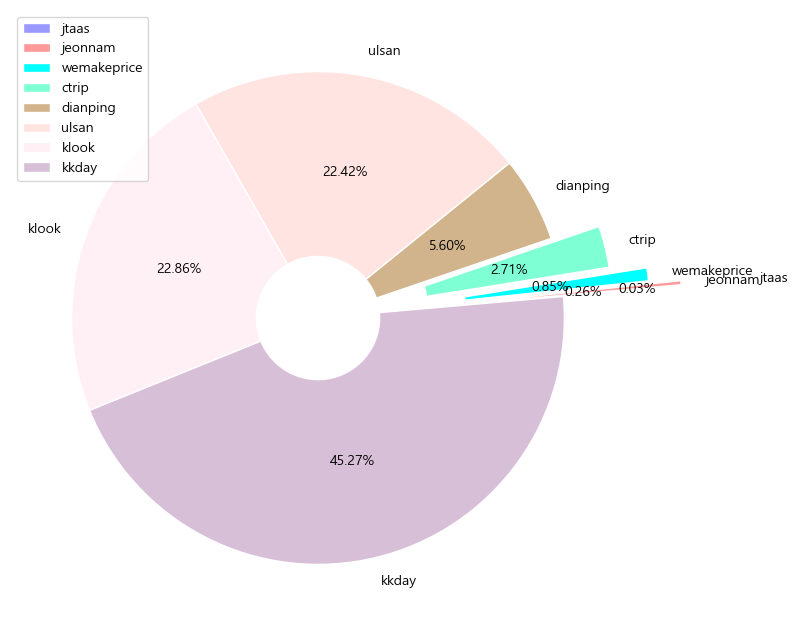

In [23]:
def get_ota_dic():

    conn = live_db_conn()
    curs = conn.cursor()

    sql = """
    SELECT id, code
    FROM ota
    """
    curs.execute(sql)

    ota = pd.DataFrame(curs.fetchall())

    curs.close()
    conn.close()

    ota_dic = {vals[0]:vals[1] for vals in ota.values}

    return ota_dic


def ota_ratio_chart():
    
    order = order_table()
    ota_dic = get_ota_dic()
    ratio = {ota_dic[i]:len(order[order['ota_id'] == i]) / len(order) for i in range(2,15) if len(order[order['ota_id'] == i]) != 0}
    ratio = dict(sorted(ratio.items(), key=lambda x:x[1], reverse=False))

    colors = ['#9999ff','#ff9999','#00FFFF','#7FFFD4','tan','mistyrose','lavenderblush','thistle']
    wedgeprops={'width': 0.75, 'edgecolor': 'w', 'linewidth': 1}
    explode = [0,0,0,0,0.2,0.35,0.48,0.70]
    plt.figure(figsize=(10,8)) # Ï∞®Ìä∏ ÏÉùÏÑ± Î∞è ÏÇ¨Ïù¥Ï¶à ÏÑ§Ï†ï
    plt.pie(ratio.values(),labels=ratio.keys(),autopct='%.2f%%',explode = explode[::-1], colors=colors[:len(ratio)],startangle=365, wedgeprops=wedgeprops)
    plt.legend(fontsize=10, loc='upper left')
    plt.show()

    return ratio

ota_ratio = ota_ratio_chart()